<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a multi-layer LSTM for forecasting

In this lab, you will use the same RNN architecure in the first lab but will instead stack [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers instead of `SimpleRNN`.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [3]:
import pandas as pd
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\DHG.csv')
data.head

<bound method NDFrame.head of       Unnamed: 0        time    open    high     low   close  volume
0              0  2015-01-05   44.06   44.06   42.68   43.60    1160
1              1  2015-01-06   43.14   43.60   43.14   43.60     250
2              2  2015-01-07   43.60   43.60   42.68   43.14    2410
3              3  2015-01-08   43.14   43.14   42.68   43.14    2430
4              4  2015-01-09   43.14   43.14   42.68   43.14    6720
...          ...         ...     ...     ...     ...     ...     ...
2421        2421  2024-09-13  107.70  107.70  106.50  106.60   13100
2422        2422  2024-09-16  106.60  107.50  106.50  106.60    9000
2423        2423  2024-09-17  106.90  107.80  106.70  107.30    6000
2424        2424  2024-09-18  106.90  108.00  106.90  107.60   16300
2425        2425  2024-09-19  107.60  107.80  107.00  107.70    7100

[2426 rows x 7 columns]>

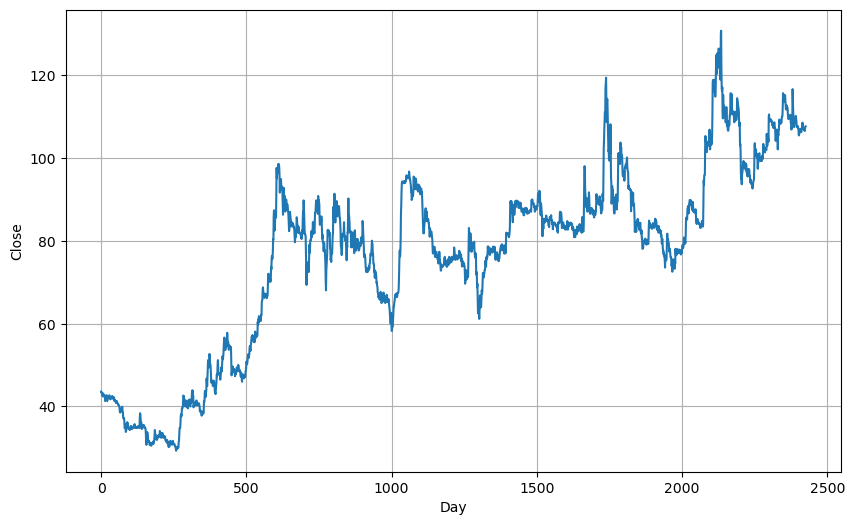

In [4]:
import csv
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\DHG.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Close')

## Split the Dataset

In [5]:
# Define the split time
split_time = 2000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [6]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 500

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [8]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [9]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-traina

## Tune the Learning Rate

As usual, you will pick a learning rate by running the tuning code below.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 11s 48ms/step - loss: 87.8603 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 2s 24ms/step - loss: 84.9773 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 2s 25ms/step - loss: 74.4091 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 2s 24ms/step - loss: 68.0710 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 2s 25ms/step - loss: 64.3321 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 2s 25ms/step - loss: 60.6418 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 2s 23ms/step - loss: 56.7061 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 2s 24ms/step - loss: 52.2710 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 2s 25ms/step - loss: 47.2997 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 2s 30ms/step - loss: 40.1883 - lr: 2.8184e-08
Epoch 11

62/62 [==============================] - 2s 26ms/step - loss: 6.0399 - lr: 1.2589e-04
Epoch 84/100
62/62 [==============================] - 2s 30ms/step - loss: 8.4886 - lr: 1.4125e-04
Epoch 85/100
62/62 [==============================] - 2s 25ms/step - loss: 9.0151 - lr: 1.5849e-04
Epoch 86/100
62/62 [==============================] - 2s 24ms/step - loss: 13.2908 - lr: 1.7783e-04
Epoch 87/100
62/62 [==============================] - 2s 26ms/step - loss: 12.5191 - lr: 1.9953e-04
Epoch 88/100
62/62 [==============================] - 2s 27ms/step - loss: 13.8785 - lr: 2.2387e-04
Epoch 89/100
62/62 [==============================] - 2s 27ms/step - loss: 12.8378 - lr: 2.5119e-04
Epoch 90/100
62/62 [==============================] - 2s 24ms/step - loss: 13.4485 - lr: 2.8184e-04
Epoch 91/100
62/62 [==============================] - 2s 24ms/step - loss: 14.5084 - lr: 3.1623e-04
Epoch 92/100
62/62 [==============================] - 2s 24ms/step - loss: 14.7684 - lr: 3.5481e-04
Epoch 93/100
62/

(1e-08, 0.001, 0.0, 30.0)

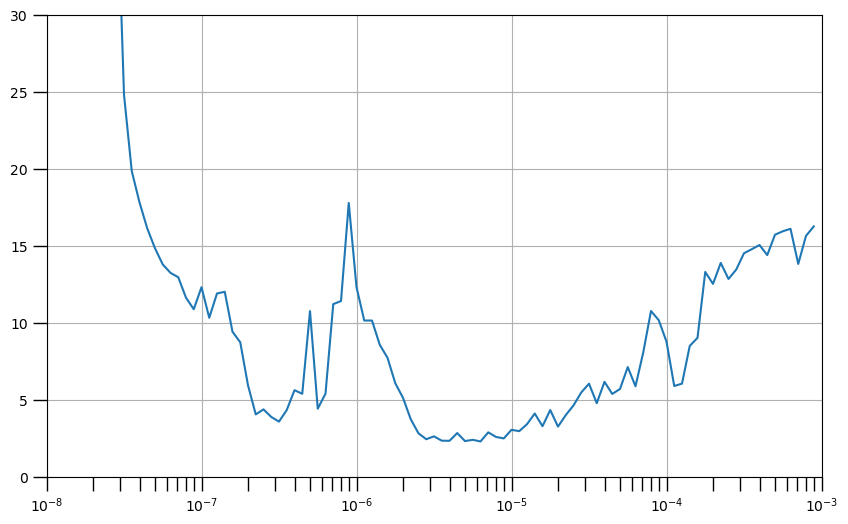

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model

You can then proceed to train the model with your chosen learning rate. 

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 4e-6
import time
start_time =time.time()
# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)
train_time_cls = time.time() - start_time
print(f'Thời gian dự đoán mô hình BiLSTM: {train_time_cls:.4f} giây')

Epoch 1/100
62/62 [==============================] - 10s 25ms/step - loss: 10.8984 - mae: 11.3834
Epoch 2/100
62/62 [==============================] - 2s 24ms/step - loss: 5.6218 - mae: 6.1020
Epoch 3/100
62/62 [==============================] - 2s 26ms/step - loss: 2.3210 - mae: 2.7751
Epoch 4/100
62/62 [==============================] - 2s 25ms/step - loss: 2.2698 - mae: 2.7215
Epoch 5/100
62/62 [==============================] - 2s 25ms/step - loss: 2.2426 - mae: 2.6991
Epoch 6/100
62/62 [==============================] - 2s 26ms/step - loss: 1.9114 - mae: 2.3528
Epoch 7/100
62/62 [==============================] - 2s 26ms/step - loss: 1.9845 - mae: 2.4310
Epoch 8/100
62/62 [==============================] - 2s 25ms/step - loss: 1.8015 - mae: 2.2421
Epoch 9/100
62/62 [==============================] - 2s 25ms/step - loss: 1.7776 - mae: 2.2139
Epoch 10/100
62/62 [==============================] - 2s 26ms/step - loss: 1.7935 - mae: 2.2349
Epoch 11/100
62/62 [==========================

62/62 [==============================] - 4s 56ms/step - loss: 1.2776 - mae: 1.7051
Epoch 87/100
62/62 [==============================] - 4s 56ms/step - loss: 1.1409 - mae: 1.5544
Epoch 88/100
62/62 [==============================] - 4s 58ms/step - loss: 1.2143 - mae: 1.6351
Epoch 89/100
62/62 [==============================] - 4s 57ms/step - loss: 1.2917 - mae: 1.7273
Epoch 90/100
62/62 [==============================] - 4s 60ms/step - loss: 1.2155 - mae: 1.6374
Epoch 91/100
62/62 [==============================] - 4s 53ms/step - loss: 1.0043 - mae: 1.4045
Epoch 92/100
62/62 [==============================] - 3s 50ms/step - loss: 1.0587 - mae: 1.4679
Epoch 93/100
62/62 [==============================] - 3s 47ms/step - loss: 1.2525 - mae: 1.6782
Epoch 94/100
62/62 [==============================] - 3s 45ms/step - loss: 1.3359 - mae: 1.7659
Epoch 95/100
62/62 [==============================] - 4s 55ms/step - loss: 1.5538 - mae: 1.9812
Epoch 96/100
62/62 [==============================] -

## Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

In [13]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

14/14 [==============================] - 14s 22ms/step
Thời gian dự đoán mô hình DNN: 13.9742 giây


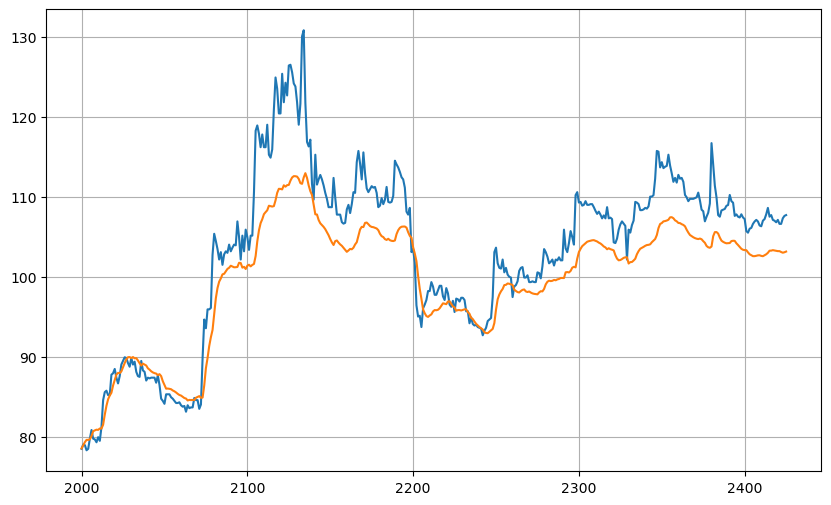

In [14]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]
start_time=time.time()
# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

train_time_cls = time.time() - start_time
print(f'Thời gian dự đoán mô hình DNN: {train_time_cls:.4f} giây')
# Plot the results
plot_series(time_valid, (x_valid, results))

You can then generate the metrics to evaluate the model's performance.

In [15]:
mse=np.mean(np.square(x_valid - results))
print('MSE=', mse)
mean_error_percent = np.mean(np.abs((x_valid - results) / x_valid))
accuracy = 1 - mean_error_percent
print('Accuracy=', accuracy)
print('mean_error_percent=', mean_error_percent)

MSE= 26.161334447201945
Accuracy= 0.9631777086065961
mean_error_percent= 0.03682229139340391


## Wrap Up

This concludes this short exercise on using LSTMs for time series forecasting. Next week, you will build upon this and add convolutions. Then, you will start to move away from synthetic data and use real-world datasets. See you there!